### Preprocessing: finding toxic n-grams in Wikipedia dataset

For each n-gram up to n=3, we consider:
- $N_t$ = number of appearances in comments marked toxic
- $N_n$ = number of appearances in comments not marked toxic

We then consider the ratio $\frac{N_t}{N_t+N_n}$ as a measure of toxicity of a particular n-gram. The following code looks for most toxic n-grams up to n=3 in the Wikipedia dataset.

In [5]:
# Step 1: collect n-grams from data

import sys, os, re, csv, numpy as np, pandas as pd

train = pd.read_csv('data/toxic_train.csv')
train_toxic = train[train['toxic']==1]
data = train['comment_text']
words = {}
bigrams = {}
trigrams = {}

# this takes a couple minutes
n = len(data)
for i in range(n):
    s = train['comment_text'][i]
    tokens = [string for string in re.split('[\s\?!\.,():]', s.lower()) if string != ""]
    for j in range(len(tokens)):
        word = tokens[j]
        if not word in words:
            words[word] = [0,0]
        words[word][1] += 1
        if train['toxic'][i] == 1:
            words[word][0] += 1
        if j < (len(tokens) - 1):
            bigram = tokens[j] + ' ' + tokens[j+1]
            if not bigram in bigrams:
                bigrams[bigram] = [0,0]
            bigrams[bigram][1] += 1
            if train['toxic'][i] == 1:
                bigrams[bigram][0] += 1
        if j < (len(tokens) - 2):
            trigram = tokens[j] + ' ' + tokens[j+1] + ' ' + tokens[j+2]
            if not trigram in trigrams:
                trigrams[trigram] = [0,0]
            trigrams[trigram][1] += 1
            if train['toxic'][i] == 1:
                trigrams[trigram][0] += 1
    if i % 1000 == 0 or i == n-1:
        sys.stdout.write('\r')
        sys.stdout.write("Progress: %d / %d" % (i,n))
        sys.stdout.flush()

Progress: 159000 / 159571

In [6]:
# Step 2: compute frequencies
freqs_one = {}
freqs_two = {}
freqs_three = {}

for word in words:
    if words[word][1] > 200:
        freqs_one[word] = float(words[word][0])/words[word][1]
        
for word in bigrams:
    if bigrams[word][1] > 100:
        freqs_two[word] = float(bigrams[word][0])/bigrams[word][1]
        
for word in trigrams:
    if trigrams[word][1] > 50:
        freqs_three[word] = float(trigrams[word][0])/trigrams[word][1]

In [30]:
# Step 3: print top N n-grams
from operator import itemgetter
N = 10
print("%-*s %-*s %-*s" % (40, "Word", 20, "Toxicity ratio", 20, "Occurences"))
for key in dict(sorted(freqs_one.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_one[key], 20, words[key][1]))
print("------")
for key in dict(sorted(freqs_two.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_two[key], 20, bigrams[key][1]))
print("------")
for key in dict(sorted(freqs_three.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_three[key], 20, trigrams[key][1]))

Word                                     Toxicity ratio       Occurences          
cocksucker                               1.0                  546                 
mothjer                                  1.0                  489                 
cocksucking                              1.0                  290                 
niggas                                   1.0                  345                 
cuntbag                                  1.0                  226                 
securityfuck                             1.0                  227                 
fggt                                     1.0                  477                 
sexsex                                   1.0                  332                 
hanibal911you're                         1.0                  366                 
penis/////small                          1.0                  249                 
------
you faggot                               1.0                  115               

***

### Emoji analysis

We investegated the influence of emoji presence on tweet deletion rate for the Twitter dataset. The difference turned out to be very minor and not statistically significant.

Deletion rate is about 11.6% for tweets with emojis and about 10.8% for those without emojis.

In [71]:
# Compute deletion rates for tweets with and without emojis
def emojiDetection(x):
    return '\\x' in x

df = pd.read_csv('data/sample_with_label.csv')
df['emoji'] = df['TweetText'].apply(emojiDetection)

emoji_no_del = len(df[(df['emoji'] == True) & (df['WasDeleted'] == 0)])
no_emoji_no_del = len(df[(df['emoji'] == False) & (df['WasDeleted'] == 0)])
emoji_del = len(df[(df['emoji'] == True) & (df['WasDeleted'] == 1)])
no_emoji_del = len(df[(df['emoji'] == False) & (df['WasDeleted'] == 1)])

print("Deletion rate for tweets with emojis = %.3f" % (emoji_del/(emoji_no_del + emoji_del)))
print("Deletion rate for tweets without emojis = %.3f" % (no_emoji_del/(no_emoji_no_del + no_emoji_del)))

Deletion rate for tweets with emojis = 0.116
Deletion rate for tweets without emojis = 0.108


***

### Time of day analysis

We investigated the influence of the time of day on the number of deleted tweets. The code below produces a plot of deleted tweets in relation to 24-hour time of day and the same for tweets that were not deleted. Since the graphs look almost identical (except the scaled y-axis), we conclude that time of day is not a significant factor in deletion rates.

Deleted tweets by time of day:


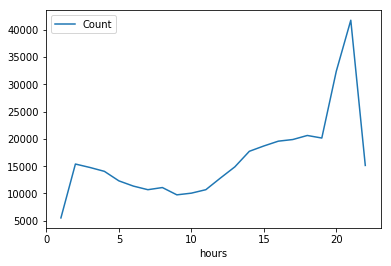

In [108]:
import re
import datetime

def hourify(s):
    start = s.find(' ')
    end = s.find(':')
    return int(s[start:end])

df = pd.read_csv('data/sample_with_label.csv')
df['hours'] = df['TweetDateTime'].apply(hourify)
df_grouped = df.groupby(['WasDeleted', 'hours']).size().reset_index()
df_grouped = df_grouped.rename({0: 'Count'}, axis=1)

print('Deleted tweets by time of day:')
df_grouped[df_grouped['WasDeleted']==0].plot(x = 'hours', y = 'Count')

Non-deleted tweets by time of day:


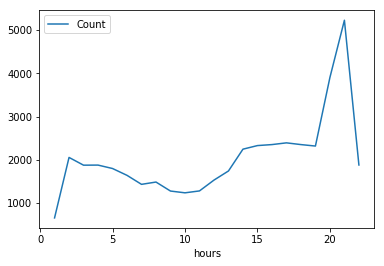

In [109]:
print('Non-deleted tweets by time of day:')
df_grouped[df_grouped['WasDeleted']==1].plot(x = 'hours', y = 'Count')

***

### First try: a Naive Bayes model for toxicity prediction

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
%matplotlib inline

In [39]:
# Load data and train model on Wikipedia dataset
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
df = pd.read_csv('data/toxic_train.csv')
X = df['comment_text']
y = df['toxic']
text_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [49]:
# example predictions
print('you suck and I fucking hate you - %.3f ' % text_clf.predict_proba(['you suck and I fucking hate you'])[0,1])
print('that was great, thank you - %.3f ' % text_clf.predict_proba(['that was great, thank you'])[0,1])

you suck and I fucking hate you - 0.962 
that was great, thank you - 0.003 


In [58]:
# predict toxic probability for Twitter dataset
twitter_df = pd.read_csv('data/sample_with_label.csv')
twitter_df.columns = ['Index','TweetID','ScreenName','TweetText','TweetDateTime','Followers','UserID','WasDeleted']
twitter_df['ToxicityProba'] = text_clf.predict_proba(twitter_df['TweetText'])[:,1]
twitter_df = twitter_df.sort_values(by=['ToxicityProba'],ascending=False)
twitter_df

,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,ToxicityProba
243293,243293,1245363598425313280,reefdude001,b'fuck shit bitch ass damn fucker tits cock wh...,2020-04-01 14:53:14,46,375348881,0,0.999824
132607,132607,1245240647910473728,theatreryoko,b'@shintsukimiai OKAY I JUST HOPE TWITTER DOES...,2020-04-01 06:44:40,65,1211650395275022336,0,0.999804
101208,101208,1245206990462345216,nolan_lacke,b'@Ronnie2K I love you man you are the best......,2020-04-01 04:30:56,45,766664388795400193,0,0.999804
100268,100268,1245206103111106561,JeffreyEAran,"b'Ohhhhh\nFuck, shit, bitch, damn, cock sucker...",2020-04-01 04:27:24,141,1174801703998283776,0,0.999793
218479,218479,1245344179057766404,starsburst,b'fuck you uglyass rat shit bastard stupid fuc...,2020-04-01 13:36:04,30,1238281735042994178,0,0.999705
99121,99121,1245205034868133895,nolan_lacke,b'No faggot no one likes you fucking bitch who...,2020-04-01 04:23:09,44,766664388795400193,0,0.999630
372902,372902,1245451863551549440,RiskPartyyy,b'@Twoluxnetic @UrMomNichole MAN WHY YOU ALL I...,2020-04-01 20:43:58,29,1001583041918242826,0,0.999494
173066,173066,1245292139183058944,chihoero,b'Fuck! Shit! Pussy! Ass! Motherfucking damn b...,2020-04-01 10:09:17,378,1241506616836534272,0,0.999401
391219,391219,1245464714127212550,OfficialDarkns,b'skribbl is dumb fucking fuck bitch ass mothe...,2020-04-01 21:35:02,19,1188206402889814016,0,0.999237
203069,203069,1245329098966089728,AriffS19,"b'@Imamofpeace FUCKING BULLSHIT, FUCK YOU ASSH...",2020-04-01 12:36:08,0,1232957371564998657,1,0.999139


In [56]:
# assess performance
def is_response_tweet(tweet):
    return '@' in tweet

n = 500
twitter_df['IsResponseTweet'] = twitter_df['TweetText'].apply(is_response_tweet)
response_tweets_df = twitter_df[twitter_df['IsResponseTweet']]
print('Top', n, 'deletion rate:', response_tweets_df.head(n)['WasDeleted'].values.sum()/n)
print('Bottom', n, 'deletion rate:', response_tweets_df.tail(n)['WasDeleted'].values.sum()/n)

Top 500 deletion rate: 0.218
Bottom 500 deletion rate: 0.06


***

### Neural network model performance on Twitter data

After training a GRU-based model on the Wikipedia data, we test its toxicity prediction performance on the Twitter dataset. The metric used is the following: we sort the tweets by our model's toxicity prediction scores and take the top $n$ and bottom $n$ cutoff sets, then compute deletion rates for both. We would like to see a high deletion rate for the top $n$ tweets and a low deletion rate for the bottom $n$ tweets.

In [31]:
%%capture
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, concatenate
from tensorflow.python.keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
pd.options.mode.chained_assignment = None

In [32]:
# Import datasets
train = pd.read_csv('data/toxic_train.csv')
test = pd.read_csv('data/toxic_test.csv')
X_train = train["comment_text"].fillna("fillna").values
X_test = test["comment_text"].fillna("fillna").values
y_train = train[["toxic"]].values
twitter_df = pd.read_csv('data/sample_with_label.csv')
twitter_text = twitter_df["TweetText"].fillna("fillna").values
twitter_y = twitter_df["WasDeleted"].fillna("fillna").values

# Tokenization of input, takes about a minute
print("Tokenizing, please wait ...")
max_features = 30000
maxlen = 100
embed_size = 300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train)+list(X_test)+list(twitter_text))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

twitter_tokenized = sequence.pad_sequences(tokenizer.texts_to_sequences(twitter_text), maxlen=maxlen)
print("Tokenizing completed.")

Tokenizing, please wait ...
Tokenizing completed.


In [35]:
# Asses performance on Twitter dataset
from tensorflow.keras.models import load_model

# uncomment these to use different saved model
model = load_model("data/models/model_twitter_only.h5")
#model = load_model("data/models/model_wiki_only.h5")
#model = load_model("data/models/model_wiki_and_twitter.h5")

tw_train_df, tw_test_df, twy_train, twy_test = train_test_split(twitter_df, twitter_y, test_size=0.25, random_state=42)
tw_train, tw_val, twy_train, twy_val = train_test_split(twitter_tokenized, twitter_y, test_size=0.25, random_state=42)

def is_response_tweet(tweet):
    return '@' in tweet
n = 500
tw_test_df['IsResponseTweet'] = tw_test_df['TweetText'].apply(is_response_tweet)
tw_test_df['ToxicityProba'] = model.predict(tw_val, verbose=1, batch_size=1024)
tw_test_df = tw_test_df.sort_values(by=['ToxicityProba'],ascending=False)
response_tweets_df = tw_test_df[tw_test_df['IsResponseTweet']]
print('Top', n, 'deletion rate:', response_tweets_df.head(n)['WasDeleted'].values.sum()/n)
print('Bottom', n, 'deletion rate:', response_tweets_df.tail(n)['WasDeleted'].values.sum()/n)

101037/101037 [==============================] - 26s 253us/sample
Top 500 deletion rate: 0.552
Bottom 500 deletion rate: 0.04


# Misspelling Analysis

We noticed immediately that our Twitter sampled dataset had a much higher count of the vocabulary size between the Wikipedia social network versus our Twitter dataset. This additional vocabulary size seemed to be coming from the trend on Twitter of either intentionally misspelling words for ironic / humourous purposes, or as a way to express the timing of how long vowels would get drawn out, such as "aaaaahhhhh", or "uhh ohhhhh", and the hundreds other possible variations on those sounds. 

Contrast this to Wikipedia's social network, where at the time of the data collection, their discourse seemed to comprise of a much more formal way of communicating, similar to the habits of email correspondence.

For this reason, we were hoping to find a network cluster that would have a low "misspelling rate" as a proxy for determining a similar formal communication style to the Wikipedia dataset.

In [12]:
import pandas as pd
from autocorrect import Speller
spell = Speller(lang='en')
from nltk import download, tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
def is_mispelling(word):
    return spell(word) != word

In [2]:
def number_of_mispellings(words):
    if len(words)==0:
        return 0
    
    count = 0
    for word in words:
        if is_mispelling(word):
            count += 1
    return count

In [7]:
def preprocess_word(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    while (doc.count('n')): 
        doc.remove('n') 
    while (doc.count('br')): 
        doc.remove('br') 
    return doc

### Warning: this cell takes a *long* time to run. Like a whole day.

In [8]:
# generate Misspelling.csv
sample_tweets_df = pd.read_csv('sample_with_label_and_clusters.csv')
sample_tweets_df['TweetTextNew'] = sample_tweets_df['TweetText'].apply(preprocess_word)
sample_tweets_df['MisspelledWordsCount'] = sample_tweets_df['TweetTextNew'].apply(number_of_mispellings)
sample_tweets_df['MisspellRate'] = sample_tweets_df['MisspelledWordsCount']/sample_tweets_df['WordsCount']
# remove NaNs
sample_tweets_df = sample_tweets_df[sample_tweets_df['MisspellRate'] == sample_tweets_df['MispellRate']]
sample_tweets_df[['TweetID','MisspellRate','MisspelledWordsCount','WordsCount','K5','K8','K10','K12']].to_csv('data/Misspelling.csv')

In [30]:
# read in Misspelling.csv
sample_tweets_df = pd.read_csv('data/Misspelling.csv')

In [33]:
sample_tweets_df.groupby('K5')['WordsCount'].sum() / sample_tweets_df.groupby('K5')['MisspelledWordsCount'].sum()

K5
0    10.031610
1    10.520557
2    10.492694
3     9.826167
4    10.352032
dtype: float64

As you can see above, there really was not any noticeable difference between the different network clusters and a misspelling rate. We expect that this could be because, although there anecdotally seems to exist different communities on Twitter that are using their accounts in a more professional setting, such as the blue-check journalists, they were not well-represented in the noise of our API listener, this was probably especially the case given the vulgarity in many of our seed words.

It would be interesting to combat this by collecting more data, and downweighting certain follows, in a similar fashion to the inverse document frequency weighting. 

For example, since there are some accounts with hundreds of millions of followers, such as Katy Perry, those accounts should have less of an influence on defining a network following cluster.

# Word vector differences across groups

In [36]:
import pandas as pd
from nltk import download, tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import numpy as np 

def preprocess_word(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    while (doc.count('n')): 
        doc.remove('n') 
    while (doc.count('br')): 
        doc.remove('br') 
    return doc

In [7]:
sample_tweets_df = pd.read_csv('data/sample_with_label_and_clusters.csv')
sample_tweets_df['TweetTextNew'] = sample_tweets_df['TweetText'].apply(preprocess_word)

Extracted word vector files for each cluster can be found in the google drive link in the readme.md file, which must be placed in the data/ directory for the next few cells to work.

In [9]:
import pickle

In [32]:
k5_clusters = sample_tweets_df['K5'].unique()
models = []
for k in k5_clusters:
    filename = 'data/wordvectors_from_cluster'+str(k)+'.pkl'
    filehandler = open(filename,'rb')
    models.append(pickle.load(filehandler)) 

In [34]:
for model in models:
    print(len(model.vocabulary.cum_table))

136296
74257
55574
57354
52265


The vocabulary size is different between each resulting word vector set, so we can compare between common words that exist in both sets.

In [37]:
vocab = []
for tweetlist in sample_tweets_df['TweetTextNew'].values:
    for tweet in tweetlist:
        vocab.append(tweet)

# Keep only those words that occured more than 250 times
unique_elements, counts_elements = np.unique(vocab, return_counts=True)
vocab_df = pd.DataFrame(unique_elements)
vocab_df.columns = ['vocab_word']
vocab_df['count'] = counts_elements
constrained_vocab = vocab_df[vocab_df['count']>250]['vocab_word'].values
constrained_vocab[0:5]

array(['able', 'absolute', 'absolutely', 'abt', 'abuse'], dtype=object)

Let's compare between two different word vector groups

In [41]:
a = []
b = []
Table = []
Row = []
for word in constrained_vocab:
    for switch in [2,1]:
        if switch == 2:
            try:
                a = models[2].wv[word]
            except:
                continue
        if switch == 1:
            try:
                b = models[4].wv[word]
            except:
                continue
    Row.append(word)
    Row.append(np.linalg.norm(a-b))
    Table.append(Row)
    Row = []
wordDiff = pd.DataFrame(Table)
wordDiff.columns = ['word','vector_diff_between_clusters_2_and_0']
wordDiff.sort_values(by='vector_diff_between_clusters_2_and_0',ascending=False).head(15)

,word,vector_diff_between_clusters_2_and_0
1103,la,14.321951
1602,que,13.393438
475,de,13.338776
621,es,12.883841
381,completa,12.873160
1711,saga,12.834828
606,encasitaconchollometro,12.804353
604,en,12.761955
596,el,12.225507
689,favorito,11.891595


It's surprising to see that despite seeding the twitter dataset with english words, when we attempt to compare the linguistic characteristics between the mutual-following network clusters by inspecting the highest word vector distances, the main differences seem to be from them comprising of actual different languages. 